# Test technique Quantmetry

### **Objectif**
Cet exercice a pour objectif d'évaluer vos compétences en data science, à travers votre
connaissance des statistiques, de l'apprentissage automatique, et vos capacités en pro-
grammation.

In [788]:
# Import des librairies utiles pour l'exercice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 1. Statistiques descriptives

### 1. Décrivez le jeu de données. 
Présentez seulement les analyses et éventuels retraitements qui vous paraissent les plus pertinents et faites une premiere conclusion sur les variables à sélectionner en vue de la prédiction du succès ou de l'échec d'une
candidature.

**- Import des données**

In [562]:
# Import des données
data = pd.read_csv("Test technique - data_v1.0.csv")

**- Première analyse et feature engineering**

In [563]:
# Affichage des 5 premières valeurs
data.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


On constate plusieurs choses :
- Une anomalie au niveau des 2 premières colonnes à supprimer
- Il y a des valeurs manquantes qu'il faudra traiter par la suite
- La colonne date est sous un format peu exploitable

In [564]:
# Suppression des 2 premières colonnes inutiles
data = data.drop(["Unnamed: 0","index"], axis=1)
data.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [565]:
# Affichage de la taille du dataframe
data.shape

(20000, 11)

In [566]:
# Séparation de la variable date en 3 colonnes
split_date = data["date"].str.split("-", expand = True)
data["annee"] = split_date[0]
data["mois"] = split_date[1]
data["jour"] = split_date[2]
data = data.drop("date", axis=1)

In [567]:
data.head()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche,annee,mois,jour
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0,2012,06,02
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0,2011,04,21
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0,2012,09,07
3,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0,2011,07,01
4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0,2012,08,07


In [568]:
# Affichage d'informations statistiques sur les variables quantitatives
data.describe()

,age,exp,salaire,note,embauche
count,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,35.004521,9.500352,34974.343934,75.168762,0.114600
std,9.609169,3.012109,5003.099616,17.095926,0.318547
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,41.000000,12.000000,38358.000000,86.617500,0.000000
max,74.000000,23.000000,53977.000000,143.220000,1.000000


Nouveaux constats, il semble y avoir des valeurs aberrantes :
- Age & exp : des valeurs négatives
- note : des notes supérieures à 100

**- Outliers**

In [569]:
# Affichage du nombre de lignes aberrantes pour lesquelles l'âge est inférieur aux années d'expérience ou
data.loc[((data["age"]<data["exp"]) | (data["exp"]<0) | (data["age"]<0))].shape

(106, 13)

Etant donné le peu de valeur concernées par rapport à la taille de l'échantillon, je décide d'exclure ces éléments de l'analyse.

In [570]:
# Suppression des éléments
index = data.loc[((data["age"]<data["exp"]) | (data["exp"]<0)| (data["age"]<0))].index
data = data.drop(index)

In [571]:
# Vérification que la suppression s'est bien effectuée
data.shape

(19894, 13)

In [572]:
# Affichage du nombre de lignes aberrantes pour lesquelles la note est supérieure à 100
data.loc[data["note"]>100].shape

(1452, 13)

Malgré le nombre important de valeurs aberrantes, mais puisqu'on ne sait pas d'où viennent les erreurs (barème sur un peu plus que 100, erreurs de virgules), je fais le choix d'exclure les individus pour l'analyse

In [573]:
# Suppression des éléments
index = data.loc[data["note"]>100].index
data = data.drop(index)

**- données manquantes**

In [574]:
#Affichage des données manquantes
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pourcentage (%)'])
missing_data

,Total,Pourcentage (%)
note,113,0.612732
diplome,101,0.547663
cheveux,96,0.520551
sexe,95,0.515129
dispo,94,0.509706
exp,91,0.493439
specialite,88,0.477172
jour,87,0.471749
mois,87,0.471749
annee,87,0.471749


In [575]:
# Remplissage des notes manquantes par la moyenne
data["note"].fillna(data["note"].mean(), inplace = True)

In [576]:
# Remplissage des diplômes manquants par la modalité la plus fréquente
data["diplome"].fillna(data["diplome"].mode().iloc[0], inplace = True)

In [577]:
# Remplissage des couleurs de cheveux manquantes par la modalité la plus fréquente
data["cheveux"].fillna(data["cheveux"].mode().iloc[0], inplace = True)

In [578]:
# Remplissage des sexes manquants par la modalité la plus fréquente
data["sexe"].fillna(data["sexe"].mode().iloc[0], inplace = True)

In [579]:
# Remplissage des dispos manquantes par la modalité la plus fréquente
data["dispo"].fillna(data["dispo"].mode().iloc[0], inplace = True)

In [580]:
# Remplissage des expériences manquantes par la moyenne
data["exp"].fillna(data["exp"].mean(), inplace = True)

In [581]:
# Remplissage des spécialités manquantes par la modalité la plus fréquente
data["specialite"].fillna(data["specialite"].mode().iloc[0], inplace = True)

In [582]:
# Remplissage des jours manquants par la modalité la plus fréquente
data["jour"].fillna(data["jour"].mode().iloc[0], inplace = True)

In [583]:
# Remplissage des mois manquants par la modalité la plus fréquente
data["mois"].fillna(data["mois"].mode().iloc[0], inplace = True)

In [584]:
# Remplissage des années manquantes par la modalité la plus fréquente
data["annee"].fillna(data["annee"].mode().iloc[0], inplace = True)

In [585]:
# Remplissage des ages manquants par la modalité la plus fréquente
data["age"].fillna(data["age"].mean(), inplace = True)

In [586]:
# Remplissage des salaires manquants par la modalité la plus fréquente
data["salaire"].fillna(data["salaire"].mean(), inplace = True)

In [587]:
#Affichage des données manquantes
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Pourcentage (%)'])
missing_data

,Total,Pourcentage (%)
jour,0,0.0
mois,0,0.0
annee,0,0.0
embauche,0,0.0
dispo,0,0.0
note,0,0.0
specialite,0,0.0
diplome,0,0.0
sexe,0,0.0
salaire,0,0.0


**- Analyse des corrélations**

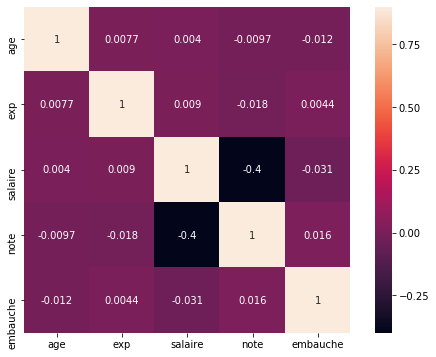

In [588]:
#Correlation map to see how features are correlated with SalePrice
corrmat = data.corr()
plt.subplots(figsize=(9,6))
sb.heatmap(corrmat, annot=True, vmax=0.9, square=True)

**- Analyses bivariées

In [713]:
# Affichage du tableau de contingence annee/embauche
pd.crosstab(data["annee"],data["embauche"])

embauche,0,1
annee,,
2010,3354,378
2011,3180,404
2012,3205,442
2013,3349,499
2014,3210,421


In [714]:
# Affichage du tableau de contingence mois/embauche
pd.crosstab(data["mois"],data["embauche"])

embauche,0,1
mois,,
01,1391,177
02,1277,127
03,1361,192
04,1346,181
05,1375,178
06,1311,174
07,1380,184
08,1396,195
09,1286,178


In [715]:
# Affichage du tableau de contingence jour/embauche
pd.crosstab(data["jour"],data["embauche"])

embauche,0,1
jour,,
01,535,74
02,574,66
03,563,73
04,486,84
05,510,71
06,520,80
07,545,66
08,661,94
09,518,72


In [720]:
# Affichage du tableau de contingence cheveux/embauche
cont = pd.crosstab(data["cheveux"],data["embauche"])
cont['Pourcentage (fraction)'] = cont[1]/(cont[0]+cont[1])
cont

embauche,0,1,Pourcentage (fraction)
cheveux,,,
blond,5007,676,0.118951
brun,4887,686,0.123093
chatain,4761,660,0.121749
roux,1643,122,0.069122


Cette variable semble peu influente sur l'embauche sauf pour les roux... s'agit-il du hasard ou d'un racisme auti-roux de la part de l'entreprise?

In [721]:
# Affichage du tableau de contingence sexe/embauche
cont = pd.crosstab(data["sexe"],data["embauche"])
cont['Pourcentage (fraction)'] = cont[1]/(cont[0]+cont[1])
cont

embauche,0,1,Pourcentage (fraction)
sexe,,,
F,6161,799,0.114799
M,10137,1345,0.117140


Cette variable semble peu influente pour le phénomène qu'on étudie

In [730]:
# Affichage du tableau de contingence diplome/embauche
cont = pd.crosstab(data["diplome"],data["embauche"])
cont['Pourcentage (fraction)'] = cont[1]/(cont[0]+cont[1])
cont

embauche,0,1,Pourcentage (fraction)
diplome,,,
bac,2237,181,0.074855
doctorat,1630,204,0.111232
licence,6438,856,0.117357
master,5993,903,0.130945


Cette variable semble avoir une influence sur embauche : les recrteurs semblent préférer les niveaux master, et exclure les personnes qui n'ont que le niveau bac

In [729]:
# Affichage du tableau de contingence specialite/embauche
cont = pd.crosstab(data["specialite"],data["embauche"])
cont['Pourcentage (fraction)'] = cont[1]/(cont[0]+cont[1])
cont

embauche,0,1,Pourcentage (fraction)
specialite,,,
archeologie,915,261,0.221939
detective,3308,405,0.109076
forage,3607,372,0.093491
geologie,8468,1106,0.115521


L'entrerpise semble largement privilégier les personnes ayant la spécialité archéologie

In [724]:
# Affichage du tableau de contingence dispo/embauche
cont = pd.crosstab(data["dispo"],data["embauche"])
cont['Pourcentage (fraction)'] = cont[1]/(cont[0]+cont[1])
cont

embauche,0,1,Pourcentage (fraction)
dispo,,,
non,10205,1311,0.113842
oui,6093,833,0.120271


La disponibilité du candidat ne semble pas avoir d'influence significative

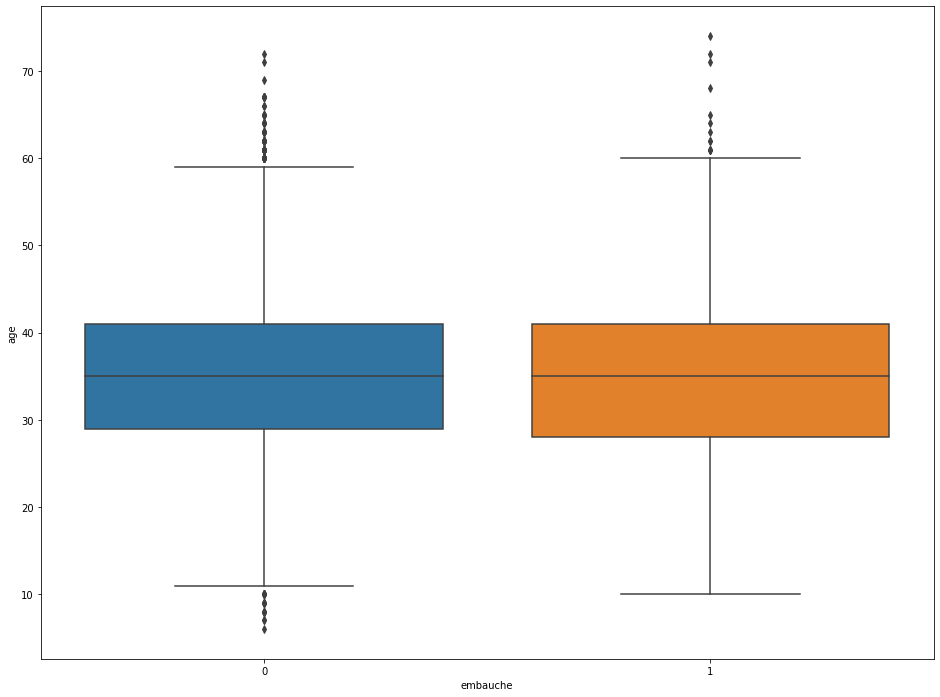

In [725]:
#Méthode ANOVA entre age et embauche
data_boxplot = pd.concat([data["embauche"], data["age"]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sb.boxplot(x="embauche", y="age", data=data_boxplot)

L'age ne semble pas avoir d'influence

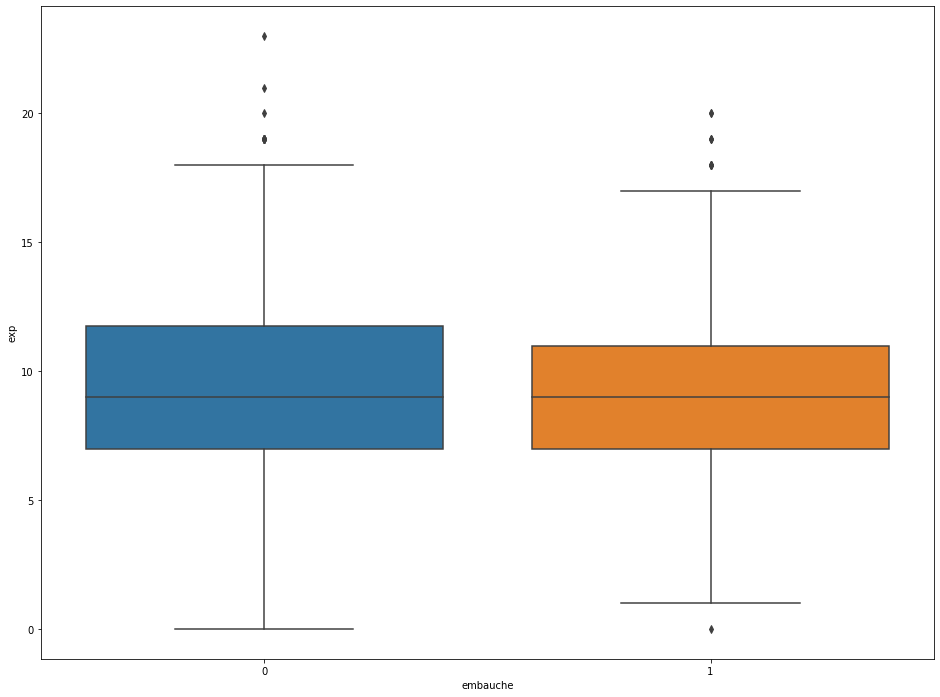

In [726]:
#Méthode ANOVA entre expérience et embauche
data_boxplot = pd.concat([data["embauche"], data["exp"]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sb.boxplot(x="embauche", y="exp", data=data_boxplot)

L'expérience ne semble pas avoir une grande influence excepté que l'entreprise semble être un peu plus frileuse à embaucher des personnes avec une grande expérience

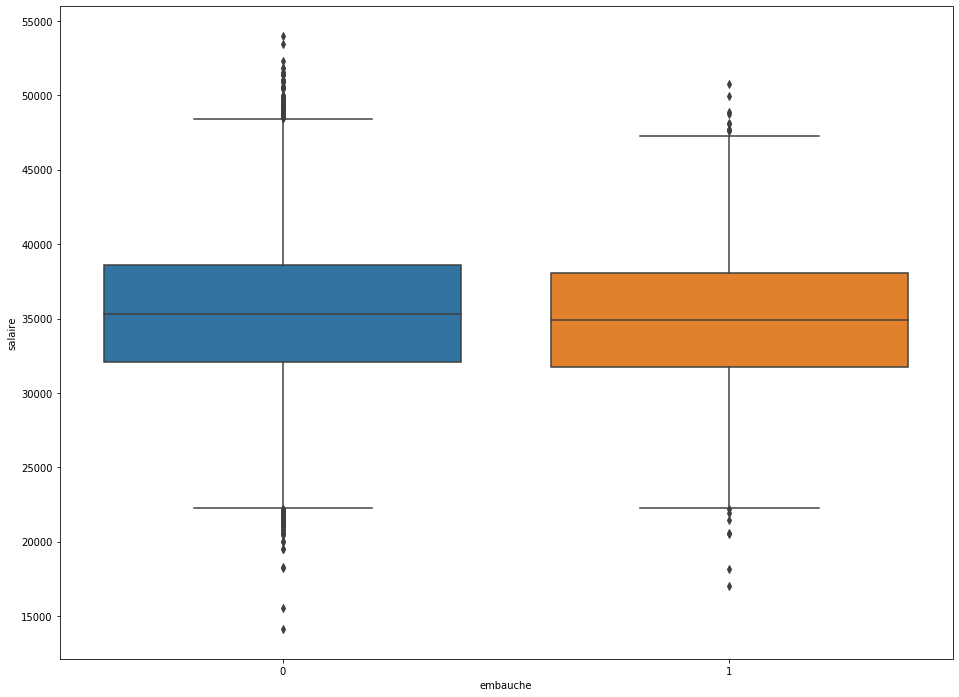

In [727]:
#Méthode ANOVA entre salaire et embauche
data_boxplot = pd.concat([data["embauche"], data["salaire"]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sb.boxplot(x="embauche", y="salaire", data=data_boxplot)

La vaiable ne semble pas influente excepté que les salaires extremums (très bas ou très hauts) sont moins présents pour les embauchés

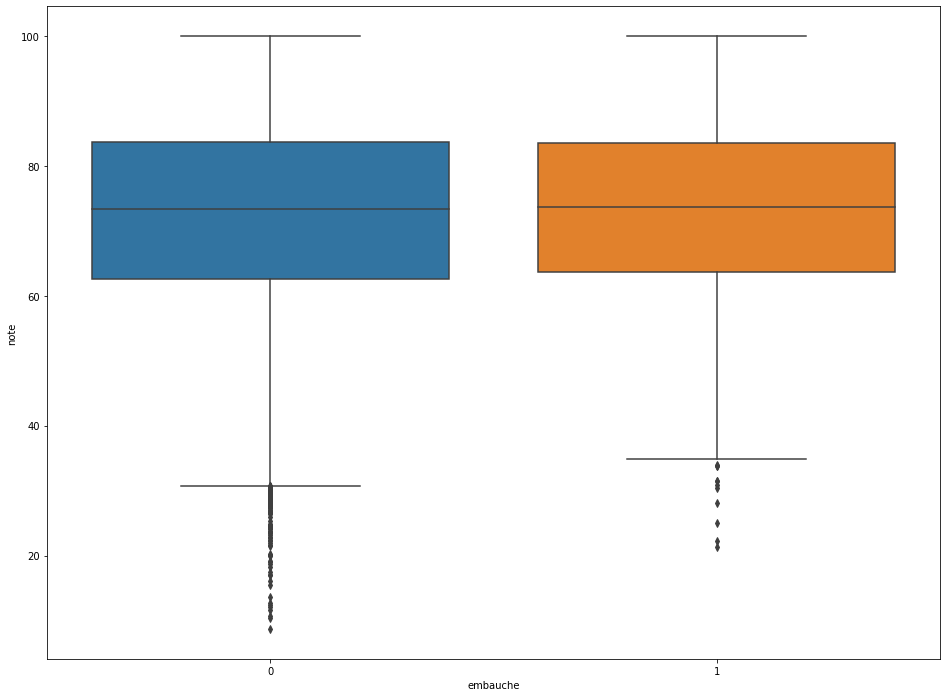

In [728]:
#Méthode ANOVA entre note et embauche
data_boxplot = pd.concat([data["embauche"], data["note"]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sb.boxplot(x="embauche", y="note", data=data_boxplot)

Il semble que les notes très basses soient éliminatoires. Pour le reste, on a une répartition légérement plus haute pour les embauchés que les non embauchés, mais rien de très significatif

### 2. Y a-t-il une dépendance statistiquement significative entre :

- (a) La spécialité et le sexe ?

In [589]:
# Affichage du tableau de contingence
cont = pd.crosstab(data["specialite"],data["sexe"])
cont

sexe,F,M
specialite,,
archeologie,900,276
detective,2174,1539
forage,1705,2274
geologie,2181,7393


In [590]:
# Réalisation d'un test statistique du chi2 et affichage de la p_value
chi2, p, dof, exp = chi2_contingency(cont)
p

0.0

- (b) La couleur de cheveux et le salaire demandé ?

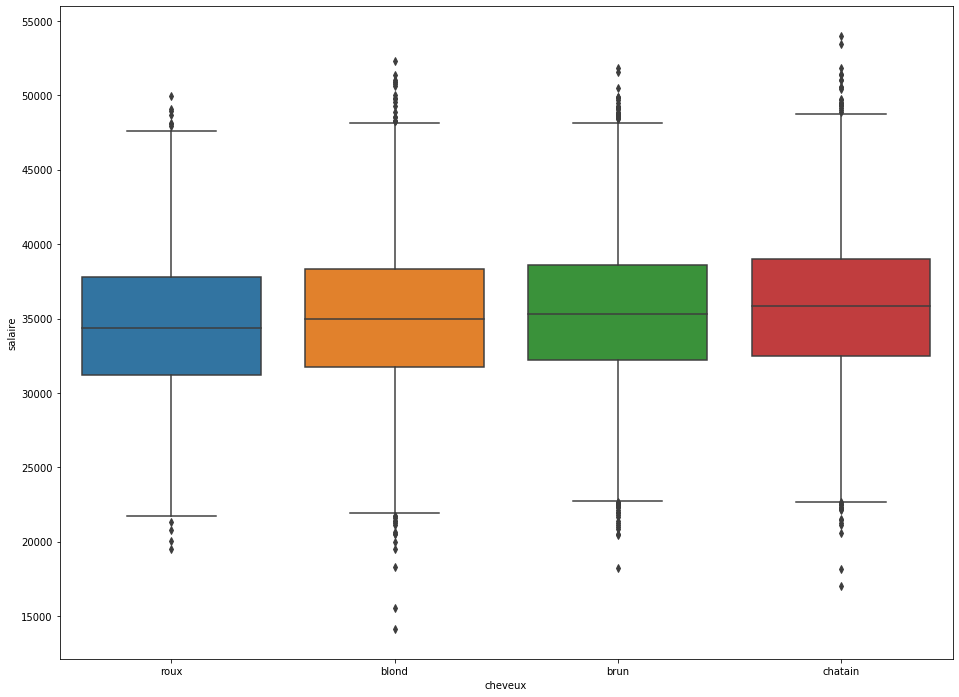

In [591]:
#Méthode ANOVA entre cheveux et salaire
data_boxplot = pd.concat([data["salaire"], data["cheveux"]], axis=1)
f, ax = plt.subplots(figsize=(16, 12))
fig = sb.boxplot(x="cheveux", y="salaire", data=data_boxplot)

In [592]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(data["cheveux"], data["salaire"])

0.007575873947954381

- (c) Le nombre d'années d'expérience et la note à l'exercice ?

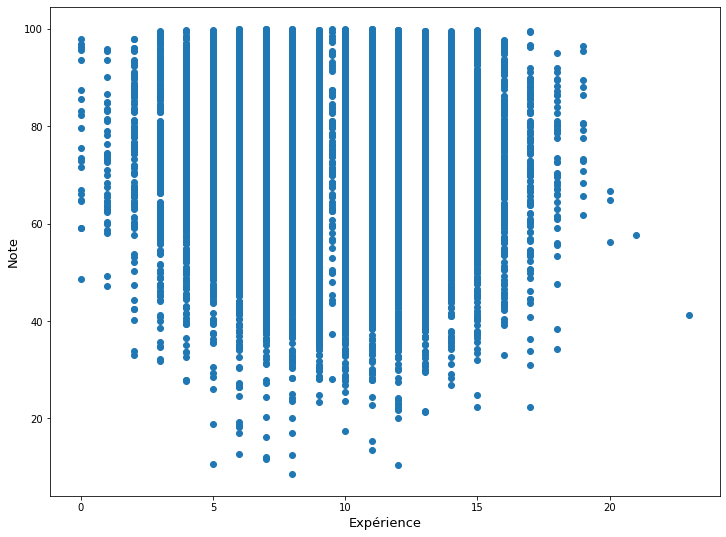

In [593]:
#Affichage du nuage de point entre les 2 variables
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(data['exp'], data['note'])
plt.ylabel('Note', fontsize=13)
plt.xlabel('Expérience', fontsize=13)
plt.show()

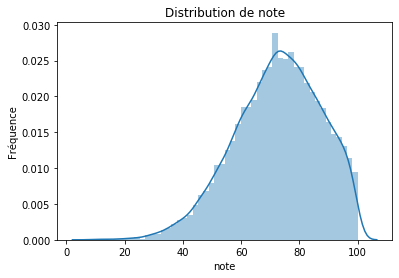

In [594]:
#Vérification de la distribution de la variable note
sb.distplot(data['note']);

plt.ylabel('Fréquence')
plt.title('Distribution de note')
plt.show()

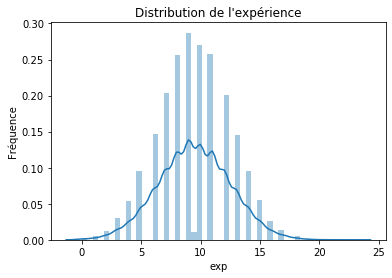

In [595]:
#Vérification de la distribution de la variable experience
sb.distplot(data["exp"]);

plt.ylabel("Fréquence")
plt.title("Distribution de l'expérience")
plt.show()

In [596]:
# Réalisation d'un test statistique du pearson et affichage de la p_value (comme on a un échantillon de grande taille, les hypothèses sont vérifiées grâce à la loi des grands nombres)
corr, p2 = pearsonr(data["exp"], data['note'])
corr, p2

(-0.01759806961118084, 0.01685460183501645)

In [597]:
# Réalisation d'un test statistique de spearman et affichage de la p_value (comme on a un échantillon de grande taille, les hypothèses sont vérifiées grâce à la loi des grands nombres)
corr2, p3 = spearmanr(data["exp"], data["note"])
corr2, p3

(-0.017894985876125313, 0.015090798963325196)

## 2. Machine learning

### 1. Concevez un modèle permettant de prédire la variable embauche et expliquez votre choix d'algorithme. Si votre modèle comporte des spécificités de paramètrage, justiez également vos choix de paramètres.

**- Standardisation des données**

In [598]:
# Normalisation des variables quantitatives
scaler = StandardScaler()
data_scaled = data.copy()
col_names = ['age', 'exp', 'salaire', 'note']
features = data_scaled[col_names]
features = scaler.fit_transform(features.values)
data_scaled[col_names] = features

In [599]:
# Vérification que les données sont bien normalisées
data_scaled.head()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche,annee,mois,jour
0,roux,-1.077747,-0.162185,-1.756474,F,licence,geologie,1.649463,non,0,2012,06,02
1,blond,-0.014868,1.171114,0.590406,M,licence,forage,-0.587915,non,0,2011,04,21
2,blond,-0.652595,1.171114,-0.020737,M,licence,geologie,0.398094,non,0,2012,09,07
3,brun,0.000000,0.837790,-0.591812,M,licence,geologie,-1.852081,non,0,2011,07,01
4,roux,-0.014868,-1.162160,-1.399165,F,licence,detective,0.627759,non,0,2012,08,07


**- Split du jeu de données**

In [600]:
y = data_scaled["embauche"]
X = data_scaled.drop("embauche", axis=1)

**- Encodage des variables qualitatives**

In [601]:
# Encodage des variables qualitatives
X = pd.get_dummies(X)

**- Définition des critères de performance**

In [758]:
#Création des fonctions d'évaluation par validation croisée (en 5 folds)
n_folds = 5

def sensibilite_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=32).get_n_splits(X)
    score = cross_val_score(model, X, y, cv = kf, scoring='recall')
    return(score.mean(), score.std())

def precision_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=32).get_n_splits(X)
    score = cross_val_score(model, X, y, cv = kf, scoring='precision')
    return(score.mean(), score.std())

**- Sélection du modèle et des hyperparamètres associés**

1. Regression logistique

In [773]:
# Calcul de la sensibilité et précision pour différentes valeurs de l'hyperparamètre par validation croisée
sensibilite_logistic =[]
precision_logistic =[]
C = np.logspace(-3, 3, 7)
for i in C:
    logistic = LogisticRegression(C = i, solver='lbfgs', class_weight = 'balanced')
    sensibilite_logistic.append(sensibilite_cv(logistic)[0])
    precision_logistic.append(precision_cv(logistic)[0])

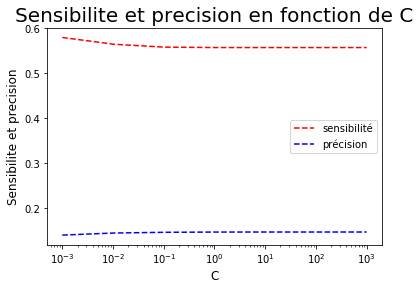

In [774]:
# Affichage du graphe correspondant
fig = plt.figure()
plt.plot(C, sensibilite_logistic, 'r--', label='sensibilité')
plt.plot(C, precision_logistic, 'b--', label='précision')

plt.title("Sensibilite et precision en fonction de C", fontsize = 20)
plt.xlabel("C", fontsize = 12)
plt.xscale('log')
plt.ylabel("Sensibilite et precision", fontsize = 12)
plt.legend()
plt.show()

2. Random Forest

In [761]:
# Calcul de la sensibilité et précision pour différentes valeurs de l'hyperparamètre par validation croisée
sensibilite_RFC =[]
precision_RFC =[]
n_estimators = [5, 10, 30, 50, 70, 100]
for i in n_estimators:
    rfc = RandomForestClassifier(n_estimators = i)
    sensibilite_RFC.append(sensibilite_cv(rfc)[0])
    precision_RFC.append(precision_cv(rfc)[0])

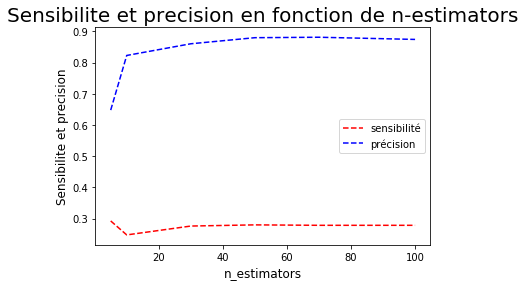

In [762]:
# Affichage du graphe correspondant
fig = plt.figure()
plt.plot(n_estimators, sensibilite_RFC, 'r--', label='sensibilité')
plt.plot(n_estimators, precision_RFC, 'b--', label='précision')

plt.title("Sensibilite et precision en fonction de n-estimators", fontsize = 20)
plt.xlabel("n_estimators", fontsize = 12)
plt.ylabel("Sensibilite et precision", fontsize = 12)
plt.legend()
plt.show()

3. SVM à noyau

In [780]:
# Calcul de la sensibilité et précision pour différentes valeurs de l'hyperparamètre par validation croisée
sensibilite_kernelsvm =[]
precision_kernelsvm =[]
C = np.logspace(1, 6, 6)
for i in C:
    kernelsvm = SVC(C = i, kernel='poly', gamma='auto')
    sensibilite_kernelsvm.append(sensibilite_cv(kernelsvm)[0])
    precision_kernelsvm.append(precision_cv(kernelsvm)[0])

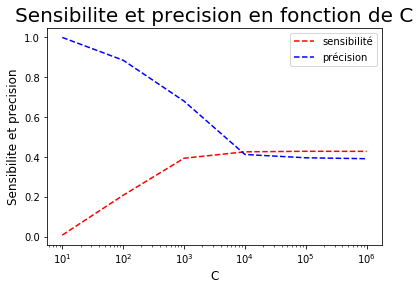

In [781]:
# Affichage du graphe correspondant
fig = plt.figure()
plt.plot(C, sensibilite_kernelsvm, 'r--', label='sensibilité')
plt.plot(C, precision_kernelsvm, 'b--', label='précision')

plt.title("Sensibilite et precision en fonction de C", fontsize = 20)
plt.xlabel("C", fontsize = 12)
plt.xscale('log')
plt.ylabel("Sensibilite et precision", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
# Calcul de la sensibilité et précision pour différentes valeurs de l'hyperparamètre par validation croisée
sensibilite_kernelsvm =[]
precision_kernelsvm =[]
gamma = np.logspace(-3, 2, 6)
for i in C:
    kernelsvm = SVC(C = 1000, kernel='poly', gamma=gamma)
    sensibilite_kernelsvm.append(sensibilite_cv(kernelsvm)[0])
    precision_kernelsvm.append(precision_cv(kernelsvm)[0])

In [ ]:
# Affichage du graphe correspondant
fig = plt.figure()
plt.plot(C, sensibilite_kernelsvm, 'r--', label='sensibilité')
plt.plot(C, precision_kernelsvm, 'b--', label='précision')

plt.title("Sensibilite et precision en fonction de C", fontsize = 20)
plt.xlabel("C", fontsize = 12)
plt.xscale('log')
plt.ylabel("Sensibilite et precision", fontsize = 12)
plt.legend()
plt.show()

Je fais le choix du SVM à noyau, et du paramètre C=1000, qui semble le plus équilibrer sensibilité et précision

### 3. Décrivez et justifiez le critère de performance utilisé.

**- sensibilité du modèle**

In [782]:
print("la sensibilité du modèle est de : ", sensibilite_kernelsvm[2])

la sensibilité du modèle est de :  0.3931943445962137


In [783]:
print("la précision du modèle est de : ", precision_kernelsvm[2])

la précision du modèle est de :  0.6800749506915224


2. Variables les plus influentes du modèle

In [785]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [786]:
kernelsvm = SVC(C = 100, kernel='poly', gamma='auto')
kernelsvm.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [790]:
kernelsvm.coef_

AttributeError: coef_ is only available when using a linear kernel

In [787]:
model = SelectFromModel(kernelsvm, prefit=True)

AttributeError: coef_ is only available when using a linear kernel